In [1]:
# open files in generations/
import pandas as pd
import os
import re

In [2]:
# open files in generations directory
def open_files(directory):
    files = os.listdir(directory)
    files.sort()
    return files

In [3]:
files = open_files('generations-new')

models_generations = {}
for file in files:
    model = model = re.sub(r"^fine-tuned-|-decoding-\d+.csv", "", file)
    gen = re.search(r"decoding-\d+", file).group()
    print(model, gen)
    if model == 'baseline':
        continue

    if model not in models_generations:
        models_generations[model] = {}
    if gen not in models_generations[model]:
        models_generations[model][gen] = {}

    models_generations[model][gen] = pd.read_csv('generations/' + file)

Ministral-8B-Instruct-2410 decoding-2


In [4]:
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
labels = [
    'RHETORICAL QUESTION',
    'HYPERBOLE',
    'OTHER',
    'ANALOGY',
    'EUPHEMISM',
    'IM:FALSE ASSERTION',
    'EX:CONTEXT SHIFT',
    'EX:OXYMORON PARADOX'
]

for model in models_generations:
    #for gen in models_generations[model]:
    print(model)
    df = models_generations[model]['decoding-2']
        
    y_true = df['actual']
    y_pred = df['prediction']

    report = classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0.0) #output_dict=True
    print(report)
    #break


Ministral-8B-Instruct-2410
                     precision    recall  f1-score   support

RHETORICAL QUESTION     0.6000    0.8182    0.6923        22
          HYPERBOLE     0.5000    0.3750    0.4286         8
              OTHER     0.2941    0.2500    0.2703        20
            ANALOGY     0.5357    0.5769    0.5556        26
          EUPHEMISM     0.0000    0.0000    0.0000         8
 IM:FALSE ASSERTION     0.3000    0.2500    0.2727        12
   EX:CONTEXT SHIFT     0.2143    0.1667    0.1875        18
EX:OXYMORON PARADOX     0.2903    0.3214    0.3051        28

          micro avg     0.4000    0.3944    0.3972       142
          macro avg     0.3418    0.3448    0.3390       142
       weighted avg     0.3704    0.3944    0.3782       142



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

Ministral-8B-Instruct-2410
Confusion Matrix:
                     RHETORICAL QUESTION  HYPERBOLE  OTHER  ANALOGY  \
RHETORICAL QUESTION                   18          0      0        1   
HYPERBOLE                              1          3      1        0   
OTHER                                  1          2      5        2   
ANALOGY                                4          0      2       15   
EUPHEMISM                              2          0      2        0   
IM:FALSE ASSERTION                     1          0      0        2   
EX:CONTEXT SHIFT                       1          0      5        2   
EX:OXYMORON PARADOX                    2          1      2        6   

                     EUPHEMISM  IM:FALSE ASSERTION  EX:CONTEXT SHIFT  \
RHETORICAL QUESTION          2                   1                 0   
HYPERBOLE                    0                   0                 2   
OTHER                        1                   1                 1   
ANALOGY                    

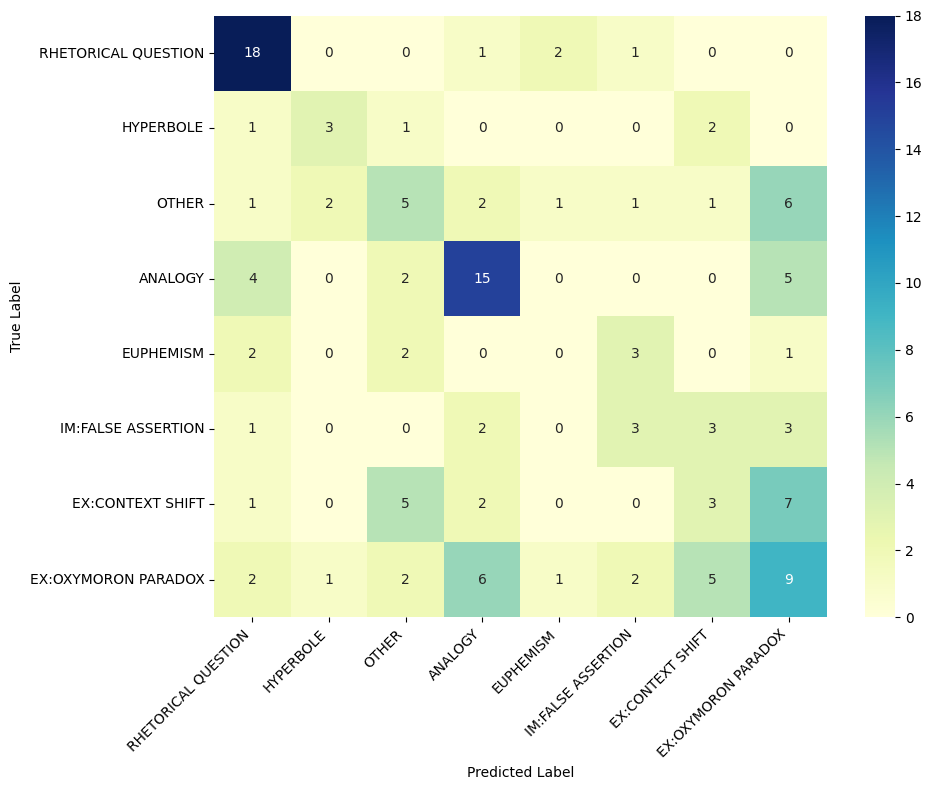

In [14]:
for model in models_generations:
    #for gen in models_generations[model]:
    print(model)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    print("Confusion Matrix:")
    print(cm_df)

    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()